# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Remarks`: Yeyyyyy panalo raw toh sa Sensiitivity Analysis

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab, you'll need this :)

#!pip install imageio opencv-python tqdm seaborn scikit-learn pandas matplotlib mediapipe

#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 # For Windows
#!pip3 install torch torchvision torchaudio # For Linux

#!pip install pytorchvideo

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [1]:
from tqdm import tqdm
import random
import pathlib
import os

import shutil
import cv2
import mediapipe as mp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, average_precision_score

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name() # Check if GPU is available, baka mamaya sa CPU tayo nagte-training

(True, 'NVIDIA GeForce RTX 3070')

#### Visualize the data first

In [3]:
def visulize_data(fil_dir): 
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)), len(all_class_names))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        # Read the video file, get the frame, isang frame lang
        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off') #✅

#### Loading of dataset

`Note`: Implementation is taken/Inspired from [Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification) 

In [5]:
## Define the dimensions of frames in the set of frames created (Default params muna)
SIZE = 160
SEQUENCE_LENGTH = 25 # Number of frames in a sequence
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ]) #✅

- `Note`: This can be changed later on once model is okay (Edit: Ok na yan, wag na dagdagan)

In [6]:
def balance_dataset_before_split(dataset_dir):
    """
    Balance the number of files in each folder before splitting by randomly deleting excess files
    to match the lowest count.
    """
    print("\nBalancing dataset...")
    dataset_dir = pathlib.Path(dataset_dir)

    # Get all class subdirectories
    class_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
    
    # Count the number of files in each class directory
    file_counts = {class_dir: len(list(class_dir.iterdir())) for class_dir in class_dirs}
    
    # Find the lowest file count
    lowest_count = min(file_counts.values())
    
    print(f"Lowest file count across classes: {lowest_count}\n\n")

    # Balance each class directory
    for class_dir, count in file_counts.items():
        if count > lowest_count:
            excess_files = random.sample(list(class_dir.iterdir()), count - lowest_count)
            for file in tqdm(excess_files, desc=f"Balancing {class_dir.name}", unit="file"):
                file.unlink()

def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    balance_dataset_before_split(dataset_dir)

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]

    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(video_files)
        
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test 
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to directories (train, val, test)
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [7]:
## File path
file_path = './PD_Dataset/' 

In [11]:
## Split the dataset, if na-run na ng isang beses wag na i-run ule, dahil sa code na hindi pa naayos, mawawala lahat yan since na split na si dataset
#split_dataset(file_path, splits={"train": 0.7, "val": 0.20, "test": 0.10}, seed=41, selected_classes=LABELS) 


Balancing dataset...
Lowest file count across classes: 121




Processing classes:   0%|          | 0/5 [00:00<?, ?class/s]


Processing class: Squat


Moving files to test/Squat: 100%|██████████| 13/13 [00:00<00:00, 24605.57file/s]



Processing class: OverheadPress


Moving files to test/OverheadPress: 100%|██████████| 13/13 [00:00<00:00, 25443.75file/s]



Processing class: LateralRaises


Moving files to test/LateralRaises: 100%|██████████| 13/13 [00:00<00:00, 20552.56file/s]



Processing class: BarbellCurl


Moving files to test/BarbellCurl: 100%|██████████| 13/13 [00:00<00:00, 22438.66file/s]



Processing class: Deadlift


Processing classes: 100%|██████████| 5/5 [00:00<00:00, 97.55class/s]


Dataset split complete!


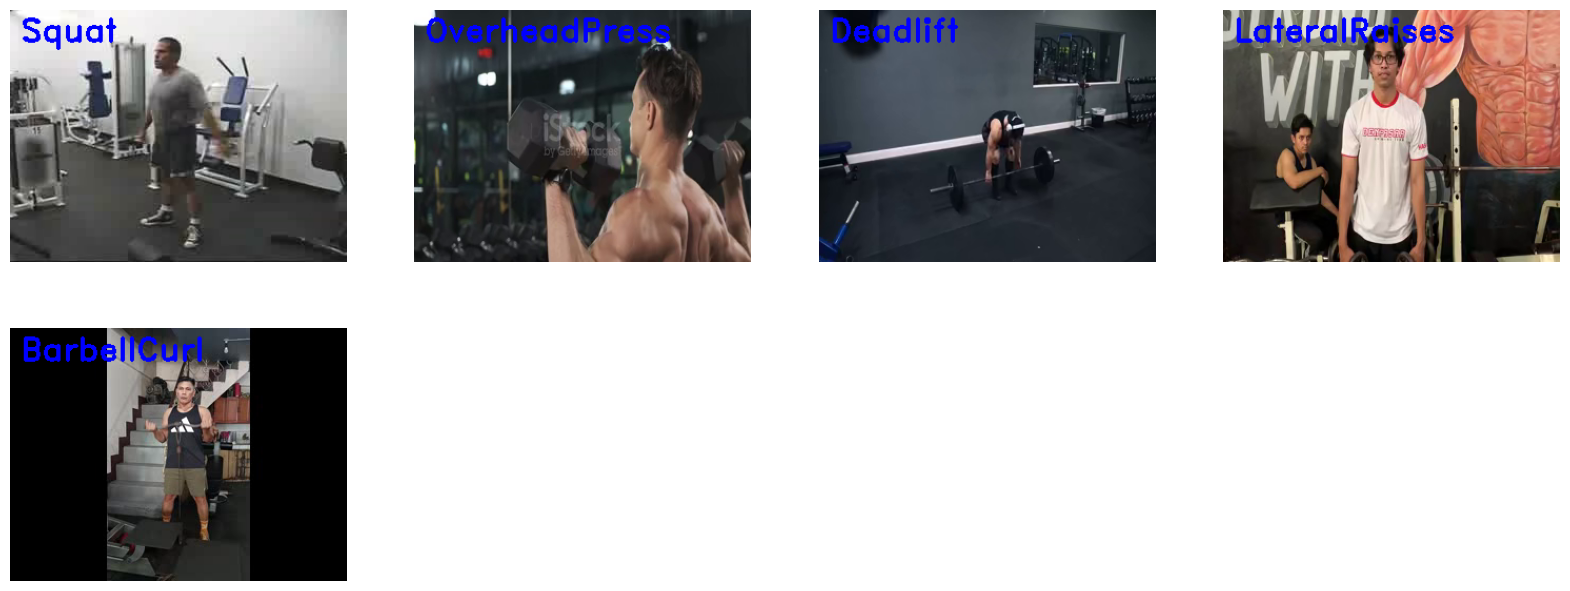

In [12]:
visulize_data(file_path + 'train/')

In [13]:
## If windows, use this
#temp = pathlib.PosixPath # Temp variable for PosixPath in case na mabaliw ka sa error ng pathlib
#pathlib.PosixPath = pathlib.WindowsPath # Redirection of PosixPath to WindowsPath

In [14]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Pre-Processing of Video Datasets

In [15]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, frame_height=224, frame_width=224, sequence_length=30):
        """
        Args:
            root_dir (str): Root directory of the dataset, containing subdirectories for each label.
            transform (callable, optional): Optional transform to be applied on a video sample.
            frame_height (int): Height of the frames after resizing.
            frame_width (int): Width of the frames after resizing.
            sequence_length (int): Number of frames to use from each video.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.sequence_length = sequence_length
        
        self.video_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Collect video paths and corresponding labels
        self._prepare_data()

        # Debugging: Check if video_paths and labels are populated
        print(f"Total videos found: {len(self.video_paths)}")
        print(f"Total labels: {len(self.labels)}")
        print(f"Class to index mapping: {self.class_to_idx}")
        print(f"Video paths: {self.video_paths[:5]}")  # Print first 5 video paths for inspection

    def _prepare_data(self):
        """
        Traverse the root directory and collect video paths and labels.
        """
        for label_idx, label_folder in enumerate(os.listdir(self.root_dir)):
            label_path = os.path.join(self.root_dir, label_folder)
            if os.path.isdir(label_path):
                # Create a mapping from label name to label index
                self.class_to_idx[label_folder] = label_idx
                self.idx_to_class[label_idx] = label_folder

                # Collect video paths for each label
                for video_name in os.listdir(label_path):
                    video_path = os.path.join(label_path, video_name)
                    if os.path.isfile(video_path) and video_path.endswith('.avi'):  
                        self.video_paths.append(video_path)
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        frames = self.load_video(video_path)
        
        if self.transform:
            frames = self.transform(frames)
        
        return torch.tensor(frames), torch.tensor(label)

    def load_video(self, video_path):
        """
        Load the video, extract frames, resize them to the target size, and apply dynamic frame skipping.
        """
        cap = cv2.VideoCapture(video_path)
        
        # Get the total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate the frame skip dynamically
        frame_skip = total_frames // self.sequence_length
        
        frames = []
        frame_count = 0
        
        while len(frames) < self.sequence_length and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Skip frames based on the dynamic frame_skip parameter
            if frame_count % frame_skip == 0:
                frame = cv2.resize(frame, (self.frame_width, self.frame_height))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            
            frame_count += 1
        
        cap.release()

        # If video is shorter than the desired sequence, pad with zeros
        if len(frames) < self.sequence_length:
            frames.extend([np.zeros((self.frame_height, self.frame_width, 3))] * (self.sequence_length - len(frames)))
        
        # Convert frames to numpy array and normalize
        frames = np.array(frames).astype(np.float32) / 255.0

        # Convert the frames to CxTxHxW format (Channels, Time, Height, Width)
        frames = np.transpose(frames, (3, 0, 1, 2))  # Change to (C, T, H, W)
        
        return frames

#### Split and Generate the datasets

In [16]:
# Instantiate the dataset
train_dataset = VideoDataset(
    root_dir=dataset_paths['train'],
    frame_height=SIZE,
    frame_width=SIZE,
    sequence_length=SEQUENCE_LENGTH,
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Total videos found: 420
Total labels: 420
Class to index mapping: {'Squat': 0, 'OverheadPress': 1, 'LateralRaises': 2, 'BarbellCurl': 3, 'Deadlift': 4}
Video paths: ['PD_Dataset/train/Squat/squat 77.avi', 'PD_Dataset/train/Squat/squat 14.avi', 'PD_Dataset/train/Squat/squat 117.avi', 'PD_Dataset/train/Squat/squat 54.avi', 'PD_Dataset/train/Squat/squat 84.avi']


In [17]:
# Instantiate the dataset
val_dataset = VideoDataset(
    root_dir=dataset_paths['val'],
    frame_height=SIZE,
    frame_width=SIZE,
    sequence_length=SEQUENCE_LENGTH,
)

val_dataset = DataLoader(val_dataset, batch_size=8, shuffle=False)

Total videos found: 120
Total labels: 120
Class to index mapping: {'Squat': 0, 'OverheadPress': 1, 'LateralRaises': 2, 'BarbellCurl': 3, 'Deadlift': 4}
Video paths: ['PD_Dataset/val/Squat/squat 65.avi', 'PD_Dataset/val/Squat/squat 67.avi', 'PD_Dataset/val/Squat/squat 35.avi', 'PD_Dataset/val/Squat/squat 94.avi', 'PD_Dataset/val/Squat/squat 1.avi']


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [18]:
def plot_history(train_loss, val_loss, train_acc, val_acc):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18.5, 10.5))

    # Loss plot
    ax1.plot(train_loss, label="Train Loss")
    ax1.plot(val_loss, label="Validation Loss")
    ax1.set_title("Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # Accuracy plot
    ax2.plot(train_acc, label="Train Accuracy")
    ax2.plot(val_acc, label="Validation Accuracy")
    ax2.set_title("Accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()

In [19]:
def get_actual_predicted_labels(dataloader, trained_model, device='cuda'):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
        dataloader: An iterable data loader with features and labels.
        trained_model: The trained PyTorch model.
        device: The device to run the model on ('cuda' or 'cpu').

    Returns:
        actual (torch.Tensor): Ground truth labels.
        predicted (torch.Tensor): Predicted labels.
    """
    actual = []
    predicted = []

    trained_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = trained_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            # Collect ground truth and predictions
            actual.append(labels)
            predicted.append(preds)

    # Concatenate all batches into single tensors
    actual = torch.cat(actual, dim=0)
    predicted = torch.cat(predicted, dim=0)

    return actual, predicted

def plot_confusion_matrix(y_actual, y_pred, labels, ds_type):
    """
    Plot a confusion matrix.

    Args:
        y_actual (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.
        labels (list): List of class names.
        ds_type (str): Type of dataset (e.g., "Train", "Validation").

    Returns:
        None: Displays the confusion matrix plot.
    """
    # Ensure tensors are on CPU and converted to NumPy arrays
    y_actual = y_actual.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_actual, y_pred)
    
    # Plot
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    ax.set_title(f'Confusion Matrix for {ds_type}')
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [20]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate precision, recall, and F1-score for each class.

    Args:
        y_actual (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing precision, recall, and F1-score per class.
    """
    # Move tensors to CPU and convert to NumPy arrays
    y_actual = y_actual.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Generate classification report
    report = classification_report(y_actual, y_pred, target_names=labels, output_dict=True)

    # Extract precision, recall, and F1-scores
    precision = {label: report[label]['precision'] for label in labels}
    recall = {label: report[label]['recall'] for label in labels}
    f1_scores = {label: report[label]['f1-score'] for label in labels}

    return precision, recall, f1_scores


In [21]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.
        average (str): 'macro' to return average F1-score, 'none' for per-class F1-scores.

    Returns:
        dict: F1-scores per class and/or macro-average F1-score.
    """
    cm = confusion_matrix(y_actual, y_pred, labels=range(len(labels)))
    tp = np.diag(cm)  # True positives (diagonal elements)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [22]:
def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual (list or array): Ground truth labels (class indices).
        y_pred (numpy.ndarray): Predicted probabilities (e.g., softmax outputs from the model).
        num_classes (int): Number of classes in the dataset.

    Returns:
        float: Mean Average Precision score.
    """
    y_actual_one_hot = np.eye(num_classes)[y_actual]  # Convert to one-hot
    aps = []
    for i in range(num_classes):
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    return np.mean(aps)

In [23]:
def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curves and calculate AUC for each class.

    Args:
        y_actual (list or array): Ground truth labels (class indices).
        y_pred (numpy.ndarray): Predicted probabilities (e.g., softmax outputs from the model).
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Create binary ground truth for the current class
        y_binary = (np.array(y_actual) == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_binary, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

In [24]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on a dataset and returns performance metrics.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset split (e.g., test or validation).
        criterion (torch.nn.Module): Loss function used to compute the loss.
        device (torch.device): Device to perform computation on ('cuda' or 'cpu').

    Returns:
        metrics (dict): Dictionary containing loss and accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)

            # Forward pass
            outputs = model(sequences)  # Model predictions
            loss = criterion(outputs, labels)  # Compute the loss
            total_loss += loss.item() * labels.size(0)  # Accumulate weighted loss

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples * 100

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
    }

    return metrics

## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

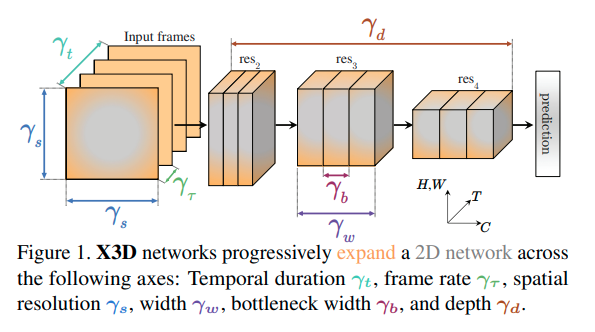

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

#### Network Building

In [25]:
from pytorchvideo.models.x3d import create_x3d

model = create_x3d(input_channel=3,
                   input_clip_length=SEQUENCE_LENGTH,
                   input_crop_size=SIZE,
                   model_num_class=len(LABELS),
                   dropout_rate=0.5,
                   width_factor=2.0,
                   depth_factor=2.2,
                   norm=torch.nn.BatchNorm3d,
                   activation=torch.nn.ReLU,


                   )
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


# Training configuration
num_epochs = 70

#### Train the model

In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Scheduler to reduce learning rate on validation loss plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0  
best_model_state = None  # Save the best model state

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_dataloader), desc="Training", unit="batch") as pbar: # May loading yan na kasama parang sa keras:)
        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.update(1)

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with tqdm(total=len(val_dataset), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, targets in val_dataset:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

                pbar.set_postfix(loss=f"{loss.item():.4f}")
                pbar.update(1)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}"
    )

if best_model_state:
    torch.save(best_model_state, "x3d_model.pth")
    print(f"\nBest model saved with Validation Accuracy: {best_val_acc:.2f}%")

print("Training complete!")

/media/nil/Extra/Documents/vscodeProjects/torchcuda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch [1/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6140]


Train Loss: 1.6075, Train Accuracy: 21.1905, Val Loss: 1.6088, Val Accuracy: 20.0000

Epoch [2/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.6188]


Train Loss: 1.6005, Train Accuracy: 27.3810, Val Loss: 1.5918, Val Accuracy: 35.0000

Epoch [3/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.6445]


Train Loss: 1.5886, Train Accuracy: 29.2857, Val Loss: 1.5669, Val Accuracy: 35.0000

Epoch [4/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.61batch/s, loss=1.6037]


Train Loss: 1.5660, Train Accuracy: 30.7143, Val Loss: 1.5178, Val Accuracy: 40.8333

Epoch [5/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.61batch/s, loss=1.6641]


Train Loss: 1.5359, Train Accuracy: 35.9524, Val Loss: 1.5007, Val Accuracy: 36.6667

Epoch [6/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.6463]


Train Loss: 1.5133, Train Accuracy: 35.7143, Val Loss: 1.4976, Val Accuracy: 37.5000

Epoch [7/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.6450]


Train Loss: 1.5027, Train Accuracy: 38.8095, Val Loss: 1.4964, Val Accuracy: 33.3333

Epoch [8/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.6360]


Train Loss: 1.4898, Train Accuracy: 39.7619, Val Loss: 1.4782, Val Accuracy: 35.8333

Epoch [9/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.5722]


Train Loss: 1.4801, Train Accuracy: 41.4286, Val Loss: 1.4771, Val Accuracy: 38.3333

Epoch [10/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.53batch/s, loss=1.6692]


Train Loss: 1.4540, Train Accuracy: 45.2381, Val Loss: 1.4666, Val Accuracy: 38.3333

Epoch [11/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.6953]


Train Loss: 1.4487, Train Accuracy: 44.0476, Val Loss: 1.4691, Val Accuracy: 36.6667

Epoch [12/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.6248]


Train Loss: 1.4298, Train Accuracy: 47.3810, Val Loss: 1.4730, Val Accuracy: 39.1667

Epoch [13/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.5750]


Train Loss: 1.4249, Train Accuracy: 47.1429, Val Loss: 1.4549, Val Accuracy: 40.8333

Epoch [14/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6820]


Train Loss: 1.4058, Train Accuracy: 49.0476, Val Loss: 1.4633, Val Accuracy: 36.6667

Epoch [15/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6071]


Train Loss: 1.4079, Train Accuracy: 48.3333, Val Loss: 1.4657, Val Accuracy: 35.8333

Epoch [16/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.7218]


Train Loss: 1.3907, Train Accuracy: 50.9524, Val Loss: 1.4970, Val Accuracy: 30.8333

Epoch [17/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57batch/s, loss=1.6393]


Train Loss: 1.3920, Train Accuracy: 50.0000, Val Loss: 1.4453, Val Accuracy: 41.6667

Epoch [18/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6182]


Train Loss: 1.3487, Train Accuracy: 55.0000, Val Loss: 1.4374, Val Accuracy: 44.1667

Epoch [19/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6207]


Train Loss: 1.3517, Train Accuracy: 54.5238, Val Loss: 1.4637, Val Accuracy: 38.3333

Epoch [20/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.6456]


Train Loss: 1.3406, Train Accuracy: 56.1905, Val Loss: 1.4431, Val Accuracy: 42.5000

Epoch [21/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.4629]


Train Loss: 1.3407, Train Accuracy: 55.4762, Val Loss: 1.4153, Val Accuracy: 44.1667

Epoch [22/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.5198]


Train Loss: 1.3213, Train Accuracy: 60.0000, Val Loss: 1.4255, Val Accuracy: 44.1667

Epoch [23/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.5974]


Train Loss: 1.2985, Train Accuracy: 61.1905, Val Loss: 1.4164, Val Accuracy: 46.6667

Epoch [24/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6303]


Train Loss: 1.3151, Train Accuracy: 58.0952, Val Loss: 1.4610, Val Accuracy: 40.8333

Epoch [25/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.6766]


Train Loss: 1.3047, Train Accuracy: 61.1905, Val Loss: 1.4137, Val Accuracy: 48.3333

Epoch [26/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.5466]


Train Loss: 1.2630, Train Accuracy: 63.8095, Val Loss: 1.4238, Val Accuracy: 45.0000

Epoch [27/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.7526]


Train Loss: 1.2820, Train Accuracy: 61.9048, Val Loss: 1.4130, Val Accuracy: 50.0000

Epoch [28/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.5840]


Train Loss: 1.2413, Train Accuracy: 68.0952, Val Loss: 1.3968, Val Accuracy: 48.3333

Epoch [29/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.6011]


Train Loss: 1.2378, Train Accuracy: 67.6190, Val Loss: 1.3844, Val Accuracy: 52.5000

Epoch [30/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57batch/s, loss=1.5523]


Train Loss: 1.2314, Train Accuracy: 67.6190, Val Loss: 1.3494, Val Accuracy: 55.0000

Epoch [31/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.5533]


Train Loss: 1.2223, Train Accuracy: 69.2857, Val Loss: 1.3897, Val Accuracy: 49.1667

Epoch [32/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.5572]


Train Loss: 1.2238, Train Accuracy: 70.0000, Val Loss: 1.3997, Val Accuracy: 47.5000

Epoch [33/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.4492]


Train Loss: 1.1905, Train Accuracy: 73.0952, Val Loss: 1.3871, Val Accuracy: 50.8333

Epoch [34/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.4862]


Train Loss: 1.1975, Train Accuracy: 73.0952, Val Loss: 1.4026, Val Accuracy: 49.1667

Epoch [35/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57batch/s, loss=1.6290]


Train Loss: 1.1834, Train Accuracy: 73.3333, Val Loss: 1.3757, Val Accuracy: 52.5000

Epoch [36/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.5206]


Train Loss: 1.1847, Train Accuracy: 72.8571, Val Loss: 1.3441, Val Accuracy: 55.0000

Epoch [37/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.4812]


Train Loss: 1.1534, Train Accuracy: 75.4762, Val Loss: 1.3867, Val Accuracy: 50.0000

Epoch [38/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50batch/s, loss=1.5093]


Train Loss: 1.1142, Train Accuracy: 79.7619, Val Loss: 1.3223, Val Accuracy: 55.0000

Epoch [39/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.54batch/s, loss=1.6669]


Train Loss: 1.1320, Train Accuracy: 77.8571, Val Loss: 1.3512, Val Accuracy: 54.1667

Epoch [40/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.5992]


Train Loss: 1.1204, Train Accuracy: 80.4762, Val Loss: 1.3166, Val Accuracy: 58.3333

Epoch [41/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.53batch/s, loss=1.4925]


Train Loss: 1.1522, Train Accuracy: 75.4762, Val Loss: 1.3204, Val Accuracy: 59.1667

Epoch [42/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.53batch/s, loss=1.3973]


Train Loss: 1.1388, Train Accuracy: 76.4286, Val Loss: 1.3663, Val Accuracy: 52.5000

Epoch [43/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.53batch/s, loss=1.3866]


Train Loss: 1.1087, Train Accuracy: 80.9524, Val Loss: 1.3292, Val Accuracy: 57.5000

Epoch [44/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.4028]


Train Loss: 1.1109, Train Accuracy: 79.2857, Val Loss: 1.3172, Val Accuracy: 55.8333

Epoch [45/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.2667]


Train Loss: 1.1169, Train Accuracy: 79.2857, Val Loss: 1.3381, Val Accuracy: 55.0000

Epoch [46/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58batch/s, loss=1.3868]


Train Loss: 1.0831, Train Accuracy: 83.3333, Val Loss: 1.2890, Val Accuracy: 61.6667

Epoch [47/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.4909]


Train Loss: 1.0754, Train Accuracy: 84.2857, Val Loss: 1.3472, Val Accuracy: 53.3333

Epoch [48/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.4478]


Train Loss: 1.1005, Train Accuracy: 80.7143, Val Loss: 1.3405, Val Accuracy: 54.1667

Epoch [49/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.4632]


Train Loss: 1.0645, Train Accuracy: 85.0000, Val Loss: 1.3218, Val Accuracy: 57.5000

Epoch [50/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.3571]


Train Loss: 1.0826, Train Accuracy: 83.5714, Val Loss: 1.3494, Val Accuracy: 54.1667

Epoch [51/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.61batch/s, loss=1.4702]


Train Loss: 1.0673, Train Accuracy: 84.5238, Val Loss: 1.3978, Val Accuracy: 48.3333

Epoch [52/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.4199]


Train Loss: 1.0459, Train Accuracy: 87.6190, Val Loss: 1.3395, Val Accuracy: 55.0000

Epoch [53/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.4490]


Train Loss: 1.0254, Train Accuracy: 88.5714, Val Loss: 1.3104, Val Accuracy: 59.1667

Epoch [54/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.3672]


Train Loss: 1.0473, Train Accuracy: 86.6667, Val Loss: 1.3311, Val Accuracy: 54.1667

Epoch [55/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59batch/s, loss=1.4447]


Train Loss: 1.0273, Train Accuracy: 89.2857, Val Loss: 1.3027, Val Accuracy: 59.1667

Epoch [56/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60batch/s, loss=1.4097]


Train Loss: 1.0168, Train Accuracy: 90.7143, Val Loss: 1.3204, Val Accuracy: 58.3333

Epoch [57/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.4530]


Train Loss: 1.0178, Train Accuracy: 89.7619, Val Loss: 1.2944, Val Accuracy: 58.3333

Epoch [58/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.5287]


Train Loss: 1.0461, Train Accuracy: 85.9524, Val Loss: 1.2849, Val Accuracy: 61.6667

Epoch [59/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.4680]


Train Loss: 1.0146, Train Accuracy: 90.0000, Val Loss: 1.2901, Val Accuracy: 60.0000

Epoch [60/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.2991]


Train Loss: 1.0059, Train Accuracy: 90.9524, Val Loss: 1.2974, Val Accuracy: 58.3333

Epoch [61/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50batch/s, loss=1.4567]


Train Loss: 1.0431, Train Accuracy: 86.9048, Val Loss: 1.3086, Val Accuracy: 60.0000

Epoch [62/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.53batch/s, loss=1.4500]


Train Loss: 0.9937, Train Accuracy: 92.3810, Val Loss: 1.2919, Val Accuracy: 59.1667

Epoch [63/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.53batch/s, loss=1.3997]


Train Loss: 1.0076, Train Accuracy: 90.2381, Val Loss: 1.2798, Val Accuracy: 62.5000

Epoch [64/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51batch/s, loss=1.4466]


Train Loss: 0.9888, Train Accuracy: 91.4286, Val Loss: 1.3093, Val Accuracy: 56.6667

Epoch [65/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.3492]


Train Loss: 1.0179, Train Accuracy: 90.0000, Val Loss: 1.2640, Val Accuracy: 65.0000

Epoch [66/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.5264]


Train Loss: 1.0196, Train Accuracy: 90.0000, Val Loss: 1.2852, Val Accuracy: 62.5000

Epoch [67/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.54batch/s, loss=1.3719]


Train Loss: 0.9896, Train Accuracy: 92.1429, Val Loss: 1.3145, Val Accuracy: 58.3333

Epoch [68/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.4524]


Train Loss: 0.9640, Train Accuracy: 95.7143, Val Loss: 1.3122, Val Accuracy: 56.6667

Epoch [69/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52batch/s, loss=1.5232]


Train Loss: 0.9767, Train Accuracy: 93.0952, Val Loss: 1.3092, Val Accuracy: 59.1667

Epoch [70/70]


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.54batch/s, loss=1.2843]

Train Loss: 0.9893, Train Accuracy: 92.6190, Val Loss: 1.2957, Val Accuracy: 60.0000

Best model saved with Validation Accuracy: 65.00%
Training complete!


- `Remarks`: Why use more than 50 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

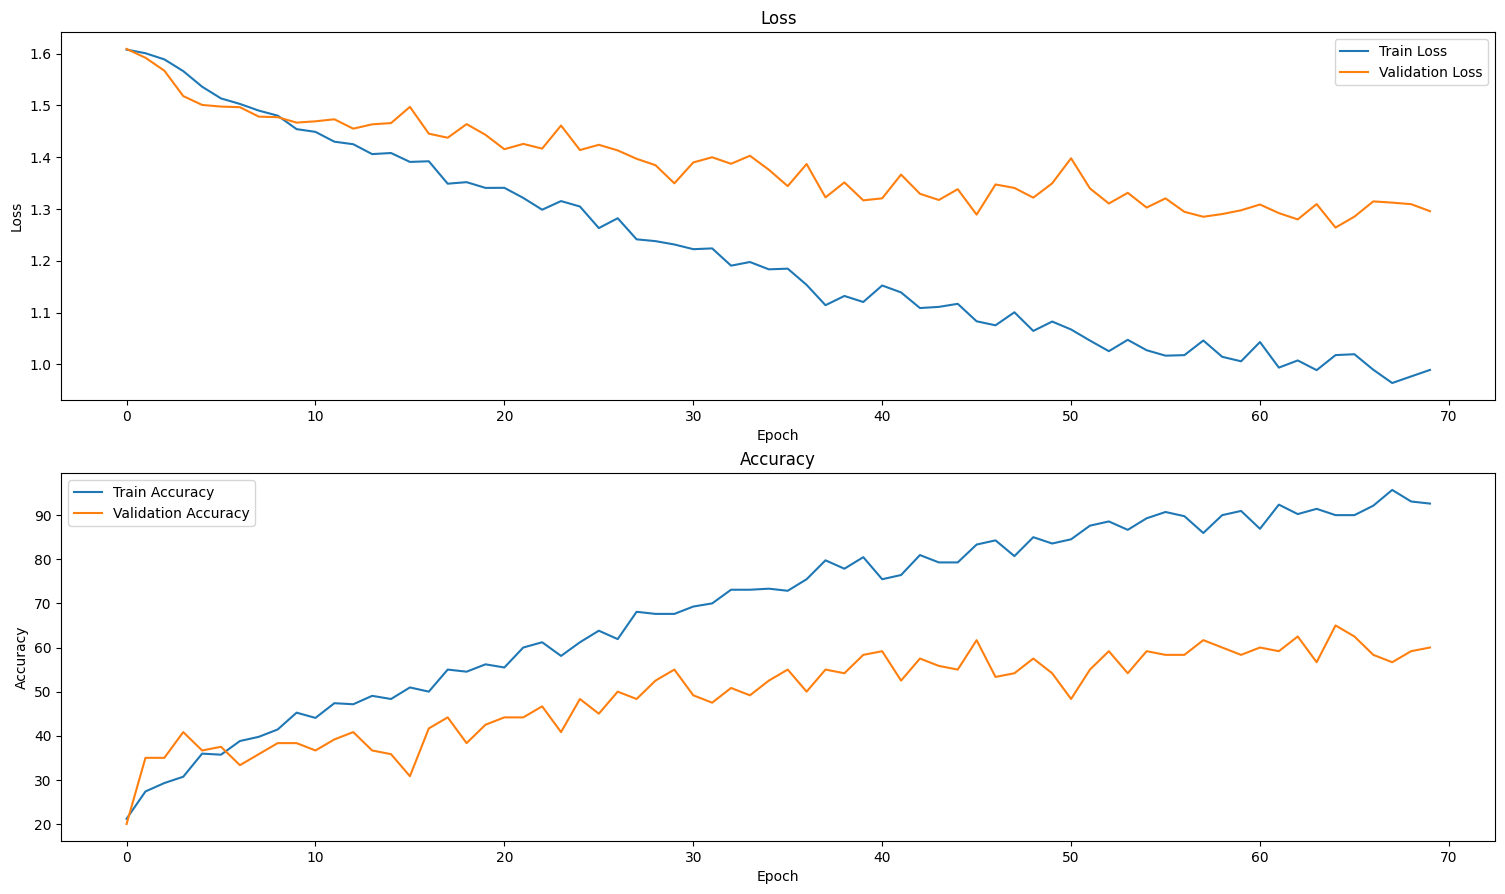

In [27]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [28]:
test_dataset = VideoDataset(
    root_dir=dataset_paths['test'],
    frame_height=SIZE,
    frame_width=SIZE,
    sequence_length=SEQUENCE_LENGTH,
)

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Total videos found: 65
Total labels: 65
Class to index mapping: {'Squat': 0, 'OverheadPress': 1, 'LateralRaises': 2, 'BarbellCurl': 3, 'Deadlift': 4}
Video paths: ['PD_Dataset/test/Squat/squat 40.avi', 'PD_Dataset/test/Squat/squat 72.avi', 'PD_Dataset/test/Squat/squat 4.avi', 'PD_Dataset/test/Squat/squat 58.avi', 'PD_Dataset/test/Squat/squat 17.avi']


In [29]:
# Evaluate the model on the validation dataset
test_metrics = evaluate_model(model, test_dataloader, criterion, device)

# Print metrics
print(f"Validation Loss: {test_metrics['loss']:.4f}")
print(f"Validation Accuracy: {test_metrics['accuracy']:.2f}%")


Validation Loss: 1.2591
Validation Accuracy: 64.62%


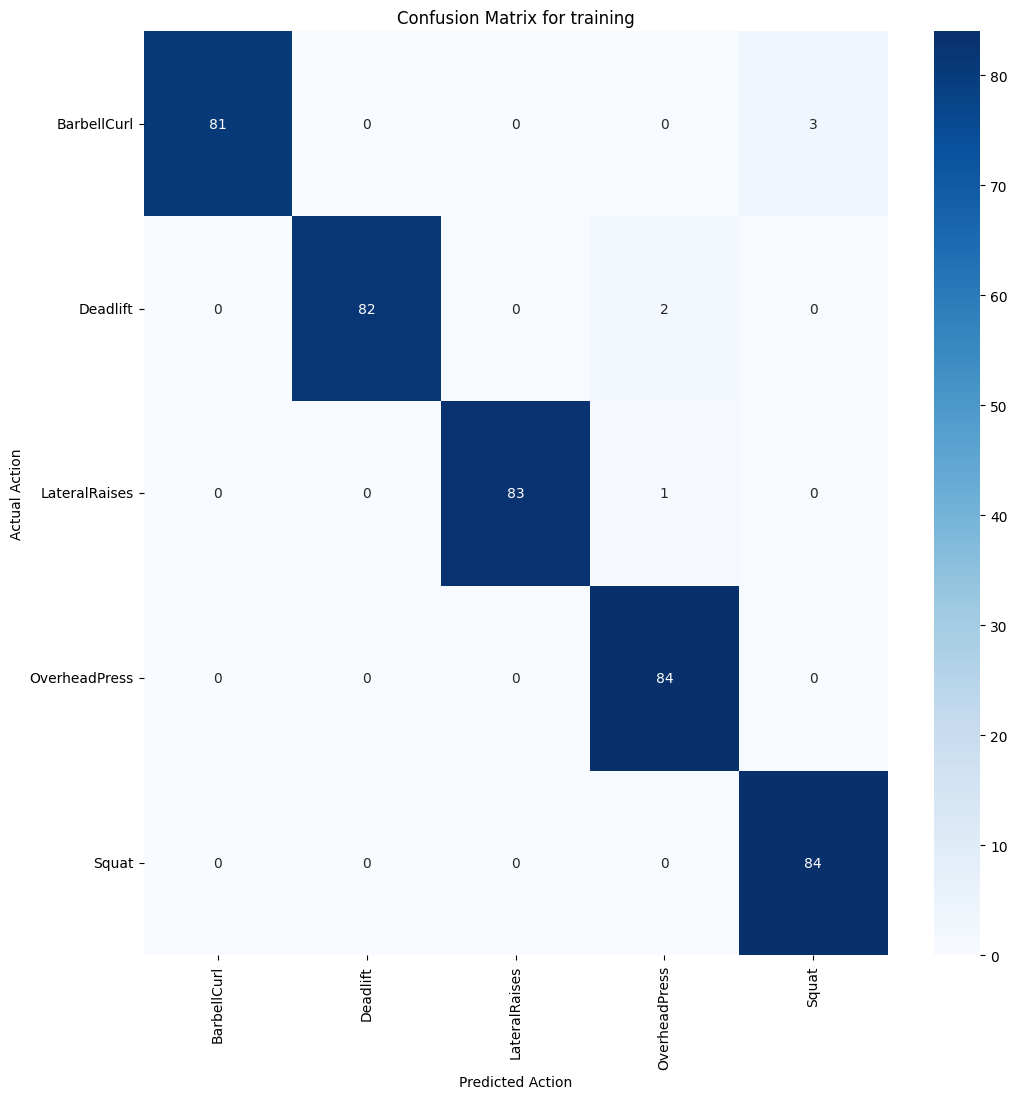

In [30]:
actual, predicted = get_actual_predicted_labels(train_dataloader, model)
plot_confusion_matrix(actual, predicted, LABELS, 'training')

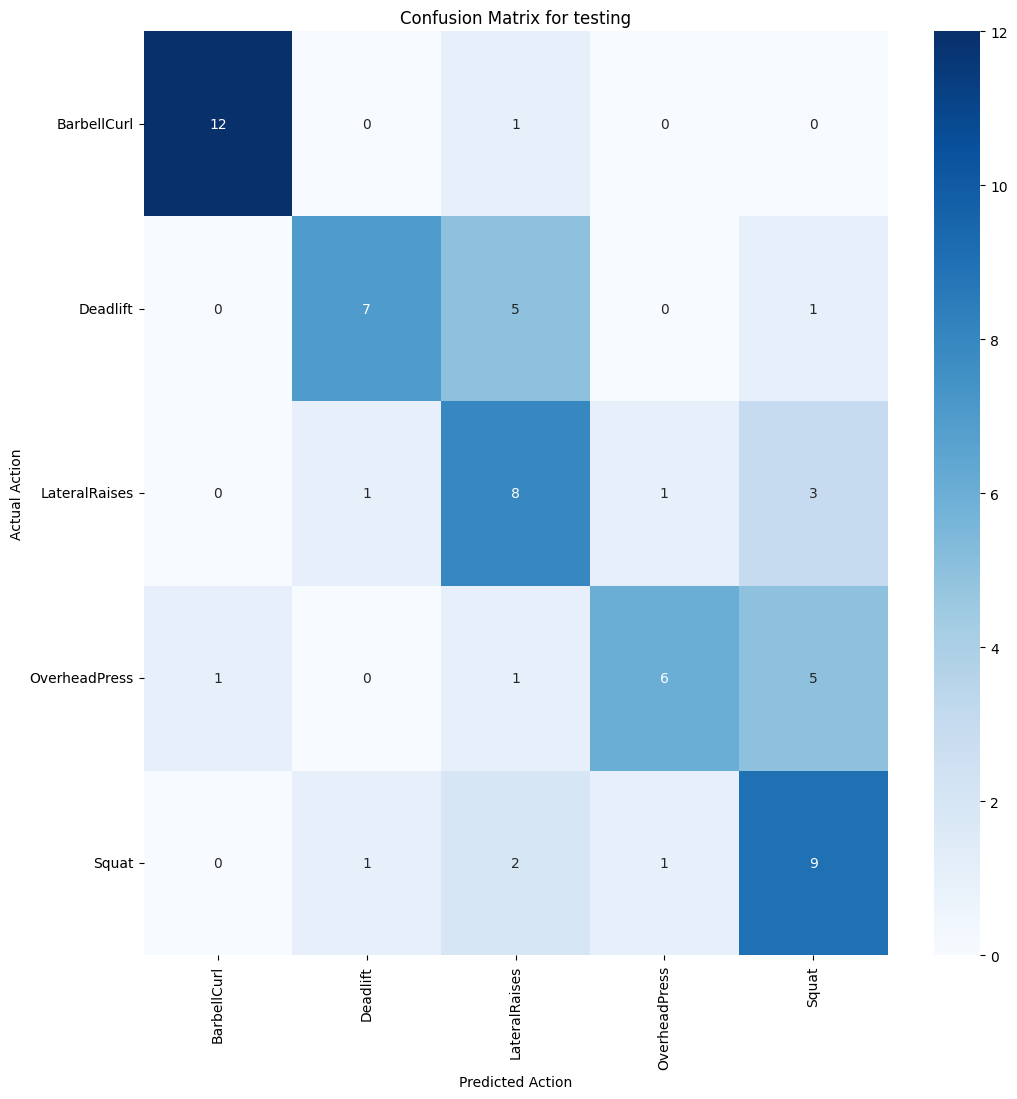

In [31]:
actual, predicted = get_actual_predicted_labels(test_dataloader, model)
plot_confusion_matrix(actual, predicted, LABELS, 'testing')

In [32]:
precision, recall, f1_scores = calculate_classification_metrics(actual, predicted, LABELS) ## Test results

In [33]:
precision

{'BarbellCurl': 0.9230769230769231,
 'Deadlift': 0.7777777777777778,
 'LateralRaises': 0.47058823529411764,
 'OverheadPress': 0.75,
 'Squat': 0.5}

In [34]:
recall

{'BarbellCurl': 0.9230769230769231,
 'Deadlift': 0.5384615384615384,
 'LateralRaises': 0.6153846153846154,
 'OverheadPress': 0.46153846153846156,
 'Squat': 0.6923076923076923}

In [35]:
f1_scores

{'BarbellCurl': 0.9230769230769231,
 'Deadlift': 0.6363636363636364,
 'LateralRaises': 0.5333333333333333,
 'OverheadPress': 0.5714285714285714,
 'Squat': 0.5806451612903226}

In [36]:
print("Average F1 Score:", np.mean([val for key, val in f1_scores.items()])) # Average F1 Score

Average F1 Score: 0.6489695250985574


## Load Model and Test

#### Test the Model

In [ ]:
## Load the trained model
from x3d import create_x3d

load_model = create_x3d(input_channel=3,
                   input_clip_length=SEQUENCE_LENGTH,
                   input_crop_size=SIZE,
                   model_num_class=len(LABELS),
                   dropout_rate=0.5,
                   width_factor=2.0,
                   depth_factor=2.2,
                   norm=torch.nn.BatchNorm3d,
                   activation=torch.nn.ReLU)
load_model.load_state_dict(torch.load("x3d_model.pth"))

device = "cuda" if torch.cuda.is_available() else "cpu"

load_model.eval()
load_model = load_model.to(device)

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

sequence_length = SEQUENCE_LENGTH  
resize_shape = (SIZE, SIZE)    

file_dir = './test_case/OverheadPress.mp4'    
webcam = 0 

cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Resize and prepare the frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]  # Convert to RGB
    frames.append(rgb_resized_frame)

    display_text = f'Activity: {predicted_label}'
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow('Cam', frame)

    if len(frames) == SEQUENCE_LENGTH:
        # Convert frames to NumPy array and normalize
        frames_array = np.array(frames) / 255.0  # Shape: (15, 224, 224, 3)

        # Rearrange dimensions to (sequence_length, height, width, channels) -> (batch_size, channels, sequence_length, height, width)
        frames_tensor = torch.tensor(frames_array, dtype=torch.float32).permute(3, 0, 1, 2)  # (channels, sequence_length, height, width)
        frames_tensor = frames_tensor.unsqueeze(0).to(device)  # (batch_size, channels, sequence_length, height, width)

        # Perform inference
        with torch.no_grad():
            prediction = load_model(frames_tensor)

        # Update predicted label
        predicted_index = torch.argmax(prediction, dim=1).item()
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()